In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import itertools
import matplotlib
from time import time
# from pandas.tools.plotting import table

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score, adjusted_rand_score, accuracy_score

from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint
from tqdm import tqdm
from copy import copy
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA, NMF, IncrementalPCA, FastICA, LatentDirichletAllocation, TruncatedSVD
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding, TSNE

matplotlib.rcParams.update({'font.size': 16})
plt.style.use("ggplot")

In [2]:
category = {}
category_sub = {}
description = {}

for nm in ["alphabay", "poseidon", "silkroad"]:
    description[nm], category[nm], category_sub[nm] = pickle.load(open("data/meta/{}_dataset.p".format(nm), "rb"))    
    print(nm, ":", len(description[nm]), "samples, \n", len(set(category[nm])),"mains, ", len(set(category_sub[nm])), "subs")

alphabay : 15222 samples, 
 12 mains,  48 subs
poseidon : 3688 samples, 
 10 mains,  36 subs
silkroad : 2137 samples, 
 1 mains,  22 subs


In [3]:
# def get_c(c):
#     if "Carding" in c:
#         return("CardedItems")
#     if "Money" in c or "Electronics" in c:
#         return("CounterfeitItems")
#     if "Fraud" in c  or "Accounts" in c or "Accohackunts & Bank Drops" in c:
#         return("Fraud")
#     if "Software" in c:
#         return("Software&Malware")
#     if "Erotica" in c or "NB" in c or "Other" in c:
#         return("OtherListings")
#     if "Security software" in c or "Security & Anonymity" in c:
#         return("Security&Hosting")
#     if "Non-lethal weapons" in c or "Pistols" in c:
#         return("Weapons")
#     if "Hash" in c or "Ecstasy" in c or "Shake/trim" in c or "Drugs" in c or "Speed" in c or "Pills" in c or "Weed" in c or "Buprenorphine" in c or "Cocaine" in c or  "Mushrooms" in c or "MDMA" in c or "Concentrates" in c or "Cannabis" in c or "Codeine" in c or "Prescription" in c or "Stimulants" in c or "Benzos" in c:
#         return("Drugs&Chemicals")
#     if "Digital products" in c or "IT" in c:
#         return("DigitalProducts")
# #     if "" in c:
# #         return("Jewels&Gold")
# #     if "" in c:
# #         return("Services")
#     if "Hacking" in c or "Making money" in c or "Info / Guides / eBooks" in c:
#         return("Guides&Tutorials")
#     else:
#         return('Er')

In [4]:
# def render_mpl_table(df):
#     size = (np.array(df.shape[::-1]) + np.array([0, 1])) * np.array([2.1, .6])
#     fig, ax = plt.subplots(figsize=size)
#     ax.axis('off')
#     mpl_table = ax.table(cellText=df.values, bbox=[0, 0, 1, 1], colLabels=df.columns)
#     mpl_table.auto_set_font_size(False)
#     mpl_table.set_fontsize(12)
#     plt.show()

In [5]:
# from IPython.display import display
# from pandas import DataFrame
# import pandas as pd

# category_ab_main = [x.get("category").split("/")[0] for x in data_ab]
# category_ab = [x.get("category") for x in data_ab]
# category_po = [x.get("category") for x in data_po]

# category_po_main = []
# for c in category_po:
#     category_po_main.append(get_c(c))
    
# for i,c in enumerate(data_ab):
#     c['category_main'] = category_ab_main[i]
# #     c['category_main'] = category_po_main[i]
    
# df = DataFrame(index=range(13))
# for x in list(set(category_ab_main)):
#     df[x] = pd.Series([y.split("/")[1][:17] for y in list(set(category_ab)) if x in y])
    
# df = df.replace(np.nan, '', regex=True)
# display(df)
# render_mpl_table(df)
# # 2

# df = DataFrame(index=range(17))
# for x in list(set(category_po_main)):
#     df[x] = pd.Series([y[:14] for y in list(set(category_po)) if x==get_c(y)])
# df = df.replace(np.nan, '', regex=True)
# display(df)
# render_mpl_table(df)

In [6]:
from nltk import word_tokenize

class keyword_estimator:
    
    def __init__(self, **params):
        self.prio_common = True
    
    def fit(self, inp, target):
        self.cv = CountVectorizer(stop_words='english', max_df=0.85)

        res = self.cv.fit_transform(inp)
        self.word_m = res.sum(0)
        
        # Normalize
        row_sums = self.word_m.sum(axis=1)
        self.word_m = (self.word_m.T / row_sums).T

        # Collect keywords for category
        self.keywords = {}
        for sub in set(target):
            try:
                self.keywords[sub] = get_words(sub)  
            except:
                self.keywords[sub] = ["none"]

    #
    # internal function: collects words for sub-categories keys
    #
    def get_words(self, sub):
        # Map words-occurance using CV's vocabulary_
        occurance = {}
        for x in self.cv.vocabulary_.items():
            occurance[x[0]] = self.word_m.item(x[1])

        # Sort dict to list
        d_key = [k for k in sorted(occurance, key=lambda k: occurance[k], reverse=True)]
        return d_key
    
    #
    # Score the estimator
    #
    def score(self, y_pred, y_true, f1=False):
        if not f1:
            return(sklearn.metrics.accuracy_score(y_pred, y_true))
        else:
            return({"Accuracy:":sklearn.metrics.accuracy_score(y_pred, y_true),
                    "weighted":f1_score(y_true, y_pred, average="weighted"),
                    "macro":f1_score(y_true, y_pred, average="macro"),
                    "micro":f1_score(y_true, y_pred, average="micro")})
    
    #
    #
    #
    def get_params(self, deep=False):
        param = {"weighted":self.prio_common}
        return(param)
    
    #
    # Do the predictions
    #
    def predict(self, inp):
#         print(self.keywords.keys())
        res = []
        for inp_ in inp:
            inp_ = word_tokenize(inp_)
            score = {}

            # iterate over all categories
            for keyw in self.keywords.keys():
                # Collect words related to the category
                for i, x in enumerate(self.keywords[keyw]):
                    if not self.prio_common:
                        i = 1
                        
                    if x in inp_:
                        try:
                            score[keyw]+=1./(i+1)
                        except:
                            score[keyw]=1./(i+1)
            try:
                res.append(max(score, key=lambda k:score[k]))
            except:
                res.append("OtherListings")
        return res

In [7]:
# #
# # Testing the keyword estimator
# #

# X_train, X_test, y_train, y_test = train_test_split(description[domain], problem, test_size=0.25, random_state=1)

# X_train = description[domain]
# y_train = problem

# clf = keyword_estimator()
# clf.fit(X_train, y_train)
# clf.prio_common=True
# pred = clf.predict(X_test)

# clf.score(pred, y_test, f1=True)

In [8]:
#
# reduce dimension
# Input: input, output_dimension 
# Out:   X, reduction_object
#

def red_dim(inp, dim_out):
    pca = TruncatedSVD(n_components=dim_out, random_state=1)
    pca.fit(inp)
    X = pca.transform(inp)
    return X, pca

In [9]:
# #
# # Oversampling
# #

# def oversample(di, cat, nr):
#     tmp=[]
#     for x in range(nr):
#         new = di.get(cat)[x%len(di.get(cat))]
#         tmp.append(new)
        
#     di[cat] = di.get(cat) + tmp
    

# max_sample = max([[x, category.count(x)] for x in set(category)], key=lambda x: x[1])[1]
# print(max_sample)

# #
# # Add al description to a dictionary
# #

# di = {}
# for c,d in zip(category, description):
#     try:
#         di.get(c).append(d)
#     except:
#         di[c] = []
#         di.get(c).append(d)

# for x in di.keys():
#     if len(di.get(x)) <= max_sample:
#         oversample(di, x, max_sample-len(di.get(x)))
        
# category = []
# description = []

# for x in di.keys():
#     description += di.get(x)
#     category += [x]*len(di.get(x))

# print(len(category))
# print(len(description))

In [10]:
# ### FOR ANOMALY DETECTION

# def anom():
#     weapon = [x for x in category if u'Weapons' in x]
#     weapon_binary = [u'Weapons' in x for x in category]

#     print "weapons:", len(weapon), "("+str(len(weapon))+")"
#     print float(len(weapon))/float(len(category)-len(weapon))*100, "% weapons"

#     w_description = []
#     nw_category = copy(category)
#     nw_description = copy(description)

#     for _ in [1,2]: # remove this for 
#         for i,x in enumerate(nw_category):
#             if u'Weapons' in x:
#                 w_description.append(nw_description[i])
#                 nw_category.pop(i)
#                 nw_description.pop(i)
                
#     return weapon, weapon_binary, w_description, nw_category, nw_description

# # weapon, weapon_binary, w_description, nw_category, nw_description = anom()

In [11]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# vect = CountVectorizer(tokenizer=LemmaTokenizer())  

In [12]:
# #
# # count vectoriser - 
# # Ret: matrix containing occurance of word in document 
# #
# # print(X_train_counts) 
# #   (document, word_id, occurances)
# #   (0, 5976)	2
# #   (0, 15089)	1
# #   (0, 7283)	1
# #
# def count_word_matrix():
#     global X_train_counts
#     count_vect = CountVectorizer(tokenizer=LemmaTokenizer()) #stop_words = 'english', min_df=0.0008
#     X_train_counts = count_vect.fit_transform(description)
#     print(X_train_counts.shape)
    
# # count_word_matrix()

In [13]:
#
# Feature impact
#


def feat_impact(inp, start=10, stop=1000, step=50):    
    %matplotlib inline
    matplotlib.rcParams.update({'font.size': 16})

    cv = []
    cv.append((CountVectorizer(),'default'))
    cv.append((CountVectorizer(stop_words='english'),'stopwords'))
    cv.append((CountVectorizer(min_df=2),'minDF=4'))
    cv.append((CountVectorizer(tokenizer=LemmaTokenizer()),'Lemma'))
    cv.append((CountVectorizer(min_df=8),'minDF=6'))
    cv.append((CountVectorizer(min_df=0.01),'minDF=0.01'))
    cv.append((CountVectorizer(max_df=0.5),'maxDF=0.5'))
    cv.append((CountVectorizer(max_df=0.8),'maxDF=0.8'))


    res = [[] for _ in range(len(cv))]
    rangen = range(start, stop, step)

    for i in rangen:
        x = description[inp][:i]
        for ind, (cv_,lb) in enumerate(cv):
            feat = cv_.fit_transform(x).shape[1]
            res[ind].append(feat)

    plt.xlabel("Number of documents")
    plt.ylabel("Number of unique words")

    for ind, res_ in enumerate(res):
        plt.plot(rangen, res_, label=cv[ind][1])

    plt.title(inp)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.plot()
    plt.show()
    
# feat_impact("silkroad")
# feat_impact("poseidon")
# feat_impact("alphabay")

In [14]:
#
# Remove numbers from a sample
#
def remove_numbers(str):
    result = ''.join(i for i in str if not i.isdigit())
    return(result)


def do_remove():
    for x in description.keys():
        tmp = description[x]
        for y in tqdm(range(len(tmp))):
            description[x][y] = remove_numbers(description[x][y])

# do_remove()

In [15]:
#
# TFIDF w/o using countvectorizer (Equivalent to CountVectorizer + TfidfTransformer)
#
def tfidf(inp):
#     tfidf = HashingVectorizer(stop_words='english', n_features=100000)
#     global voce
    tfidf = TfidfVectorizer(use_idf=True,
                            stop_words='english',
                            min_df = 3,
                            max_df= 0.25,
#                             vocabulary=voce,
                            sublinear_tf=True)
#     tfidf.fit(inp)
#     voce = tfidf.vocabulary_
    return tfidf.fit_transform(inp), tfidf.vocabulary_

In [16]:
# #
# # Problem and target 
# # #
# domain = "poseidon"
# problem = category[domain] #[190:3690]
# input_data, vocab = tfidf(description[domain]) #[190:3690])
# problem_numeric = [sorted(list(set(category[domain]))).index(x) for x in problem]

# print("Samples:", len(problem))
# print("Features:", input_data.shape[1])

In [17]:
# pprint(sorted(list(set(category["alphabay"]))))
# pprint(sorted(list(set(category["poseidon"]))))
# print(len(category["poseidon"]))
# # description["Poseidon"].append("Jewel&Gold")
# # description["Poseidon"].append("Services")
# # category["Poseidon"].append("Jewels&Gold")
# # category["Poseidon"].append("Services")

In [18]:
#
# clf = list of estimators
#

def create_clf(inp_):
    X_train, X_test, y_train, y_test = train_test_split(inp_, problem_numeric, test_size=0.25, random_state=1)

    clf = VotingClassifier([('SVC_rbf',SVC()),
                            ('Naibe_B',sklearn.naive_bayes.BernoulliNB()),
                            ('SVC_linear', sklearn.svm.LinearSVC()),
                            ('Ridge',sklearn.linear_model.RidgeClassifier()),
                            ('KNN',sklearn.neighbors.KNeighborsClassifier()),
                            ('SGD',SGDClassifier())])
    
    clf.fit(X_train, y_train)
    return(clf)

#
# ---
#

# input_ = input_data
# clf = create_clf(input_)
# clfD = (clf, input_, "none", "{} - Default".format(input_.shape[1]))

# clfs = [clfD]
# #clfs = []
# for x in tqdm([1000, 300, 5, 3]):
#     input_, pca = red_dim(input_data, x)
#     clf = create_clf(input_)
#     clfs.append((clf, input_, pca, "{}dim".format(x)))

In [19]:
# #
# # Swap datasest 
# #
# for i,x in enumerate(clfs):
#     clf_, old_, pca_, nm = x
#     print(old_.shape[1], "->", input_data.shape[1])
#     input_ = pca_.transform(input_data)
# #     input_, pca = red_dim(input_data, old_.shape[1])
# #     input_ = input_data
#     clfs[i] = (clf_, input_, pca_, nm)

In [31]:
#
# Plot result of multiple classifiers (clfs)
#


def plot_clfs(clf_list):    
    %matplotlib inline
    matplotlib.rcParams.update({'font.size': 16})

    fig = plt.figure(figsize=(25,7))

    for ind, clf_tup in tqdm(enumerate(clf_list)):
        clf_, input_, pca_, names = clf_tup
        _, X_test, _, y_test = train_test_split(input_, problem_numeric, test_size=0.25, random_state=1)
        
        clf_count = np.arange(len(clf_.estimators))
        clf_scores = [est.score(X_test, y_test) for est in clf_.estimators_]
        
        clf_names = [n[0] for n in clf_.estimators]
        plt.bar(clf_count+((.8/len(clf_list)))*ind-.35, clf_scores, width=.8/(len(clf_list)), label=names)

        plt.xticks(clf_count, clf_names)
        
    fig.autofmt_xdate()
    plt.legend(ncol=3)
    plt.title(domain)
    plt.ylim([0,1])
    plt.xlabel("Estimator")
    plt.ylabel("Accuracy")
    fig.show()
    plt.show()

# plot_clfs(clfs)

In [32]:
def eval_clf(clf_inp):    
    %matplotlib inline
    matplotlib.rcParams.update({'font.size': 16})

    classifier, input_, pca_, names = clf_inp

    X_train, X_test, y_train, y_test = train_test_split(input_, problem_numeric, test_size=0.25, random_state=1)

    fig = plt.figure(figsize=(12,8))
    clf_count = len(classifier.estimators)

    for i, clfs_ in tqdm(enumerate(classifier.estimators_)):
        y_pred = clfs_.predict(X_test)

        scores = []
        scores.append(clfs_.score(X_test, y_test))
        for avg in ['weighted', 'macro', 'micro']:
            scores.append(f1_score(y_test, y_pred, labels=list(set(problem_numeric)), average=avg))

        plt.bar(np.arange(4)+(.1*i)-0.25, scores, width=.1, label=classifier.estimators[i][0])
        plt.title(names)

    plt.xticks(range(4), ['Accuracy','F1 Micro','F1 Macro','F1 Weighted'])
    plt.legend(loc='upper left',ncol=2)
    fig.autofmt_xdate()
    plt.ylim([0,1])
    plt.xlabel("Evaluation method")
    plt.ylabel("Accuracy")
    fig.show()
    plt.show()
    
    
# for clf_ in clfs:
#     eval_clf(clf_)

In [33]:
#
# Plot confussion matrix
#


def plot_confusion_matrix(clf, normalize=False):    
    %matplotlib inline
    matplotlib.rcParams.update({'font.size': 16})

    classes = sorted(list(set(problem)))
    classifier, input_, pca_, names = clf
    # classifier = classifier.estimators_[4]

    X_train, X_test, y_train, y_test = train_test_split(input_, problem_numeric, test_size=0.25, random_state=1)
    
    y_pred = classifier.predict(X_test)
    print("Accuracy:",classifier.score(X_test, y_test))
 
    cm = confusion_matrix(y_test, y_pred)
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix \n {}'.format(names)
    else:
        title = 'Confusion matrix \n {}'.format(names)
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.set_size_inches(10, 10) #(22, 14)

    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0., vmax=cm.max())
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() * 0.85
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] < 0.01:
            continue
        if normalize:
            thresh = .64
            val = str(round(cm[i, j]*100,2)).split(".")[0]+'%'
        else:
            val = cm[i, j]
            
        if cm[i, j] > thresh:
            cl="white"
        else:
            cl="black"
            
        plt.text(j, i, val, horizontalalignment="center", color=cl) #, alpha=cm[i,j]

#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
# plot_confusion_matrix(clfs[0])
# plot_confusion_matrix(clfs[0], normalize=True)

In [34]:
# from sklearn.model_selection import GridSearchCV

# # input_data = [X]
# X_train, y_train = X_train_tfidf_nw, nw_category
# X_train, y_train = X_train_tfidf_w, weapon

# X_test, y_test = X_train_tfidf, category
# X_test_w, y_test_w = X_train_tfidf_w, weapon
# X_test_nw, y_test_nw = X_train_tfidf_nw, nw_category

# clf = OneClassSVM()
# parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'gamma':np.arange(0,1,0.1), 'nu':np.arange(0.01,1,0.1)}
# outl = GridSearchCV(clf, parameters, scoring='accuracy', n_jobs=-1)

# outl.fit(X_train, y_train)

# # ----
# inliers = float(outl.predict(X_test).tolist().count(1))/len(y_test)*100
# print("Inliers (All): {}%".format(round(inliers,1)))

# inliers = float(outl.predict(X_test_w).tolist().count(1))/len(y_test_w)*100
# print("Inliers (Weapons): {}%".format(round(inliers,1)))

# inliers = float(outl.predict(X_test_nw).tolist().count(1))/len(y_test_nw)*100
# print("Inliers (NO Weapons): {}%".format(round(inliers,1)))

# print(outl.best_estimator_)

In [35]:
# X_train, y_train = X_train_tfidf_w, weapon

# X_test, y_test = X_train_tfidf, category
# X_test_w, y_test_w = X_train_tfidf_w, weapon
# X_test_nw, y_test_nw = X_train_tfidf_nw, nw_category

# # be = OneClassSVM()
# # be = OneClassSVM(nu=0.01, gamma=0.15, kernel='linear')
# be = IsolationForest()
# # be = GaussianMixture(n_components=33)
# # be = KernelDensity()


# be.fit(X_train, y_train)

# inliers = float(be.predict(X_test).tolist().count(1))/len(y_test)*100
# print("Inliers (All): {}%".format(round(inliers,1)))

# inliers = float(be.predict(X_test_w).tolist().count(1))/len(y_test_w)*100
# print("Inliers (Weapons): {}%".format(round(inliers,1)))

# inliers = float(be.predict(X_test_nw).tolist().count(1))/len(y_test_nw)*100
# print("Inliers (NO Weapons): {}%".format(round(inliers,1)))

In [36]:
# clf = sklearn.neighbors.KNeighborsClassifier().fit(X_train, y_train)
# print("Accuracy:",clf.score(X_test,y_test))

# from pandas import DataFrame
# col = []
# for i, da in enumerate(y_test):
#     if b'Wea' in da:
#         pred_y = clf.predict(X_test[i])[0]
#         ol = 1!=outl.predict(X_test[i])[0]
#         col.append([da,pred_y,ol])

# df = DataFrame(col,columns=["Y_true","Y_predicted","outlier"])
# print(df.loc(df["outlier"]==True))

In [37]:
# print("Hits:",df.shape[0])
# print("Wrong pred:",df.loc[df["Y_true"]!=df["Y_predicted"]].shape[0])
# print("Correct pred:",df.loc[df["Y_true"]==df["Y_predicted"]].shape[0])
# print("Outliers:",df.loc[df["outlier"]==1].shape[0])
# print("Outliers & wrong prediction:",df.loc[df["outlier"]==1][df["Y_true"]!=df["Y_predicted"]].shape[0])
# df.loc[df["Y_true"]!=df["Y_predicted"]]

In [38]:
#
# Plot X (3D)  
# Input: X (global)
#

def plot_data_3d(text=False):    
    %matplotlib inline
    matplotlib.rcParams.update({'font.size': 16})

    X3d,_ = red_dim(input_data, 3)    
    fig = plt.figure(1, figsize=(10, 8))
    ax = Axes3D(fig)
    y = problem
    for name, label in zip(list(set(problem)), list(set(y))):        
        ax.scatter(X3d[[label==t for t in y], 0], 
                  X3d[[label==t for t in y], 1],
                  X3d[[label==t for t in y], 2], 
                   label=name, 
                   s=3,
                   alpha=1)
   
        if text:
            ax.text3D(X3d[[label==t for t in y], 0].mean(),
                      X3d[[label==t for t in y], 1].mean(),
                      X3d[[label==t for t in y], 2].mean(), name)          

    plt.title(domain)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.legend(loc='upper left', ncol=2)
    ax.set_xlabel('PCA 0')
    ax.set_ylabel('PCA 1')
    ax.set_zlabel('PCA 2')
    plt.show()
    
# plot_data_3d()

In [39]:
#
# Plot X (2D)  
# Input: X2d (global)
#
    
def plot_data_2d(text=False):
    %matplotlib inline
    matplotlib.rcParams.update({'font.size': 16})

    X2d,_ = red_dim(input_data, 2)
    fig = plt.figure(figsize=(10,8))
    y = problem
    
    for name in list(set(y)):
        plt.scatter(X2d[[name==t for t in y], 0],
                    X2d[[name==t for t in y], 1],
                    label=name, 
                    s=10,
                    alpha=1,
                   )
        if text:
            plt.text(X2d[[name==t for t in y], 0].mean(),
                     X2d[[name==t for t in y], 1].mean(),
                     name)
    plt.title(domain)
    plt.xlabel("PCA0")
    plt.ylabel("PCA1")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.legend(loc='upper left', ncol=2)
    plt.show()
    
# plot_data_2d()

In [40]:
#
# Scree plot
#

def scree(dim=1000, threshold=.9):
    matplotlib.rcParams.update({'font.size': 13})
    xRed_, pca2 = red_dim(input_data, dim)


    plt.ylim(0)
#     plt.text(1,0.85,"Number of components\n"+str(input_data.shape[1]))
    var_rat = np.cumsum(pca2.explained_variance_ratio_)
    var = np.cumsum(pca2.explained_variance_)
    var = [float(i)/pca2.explained_variance_[0] for i in pca2.explained_variance_]

    %matplotlib inline
    matplotlib.rcParams.update({'font.size': 16})
    plt.ylabel("Variance")
    plt.xlabel("Components")
    plt.title("{}\n{} Features".format(domain, input_data.shape[1]))
    plt.plot(var_rat, label="Cumulative variance ratio")
    plt.plot(var, label="Normalized variance ratio")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim([0,1])
    plt.show()
    
    for i, x in enumerate(var_rat):
        if x > threshold:
            return i
    return dim
        
# scree(100, .95)

Samples: 15222
Features: 35198


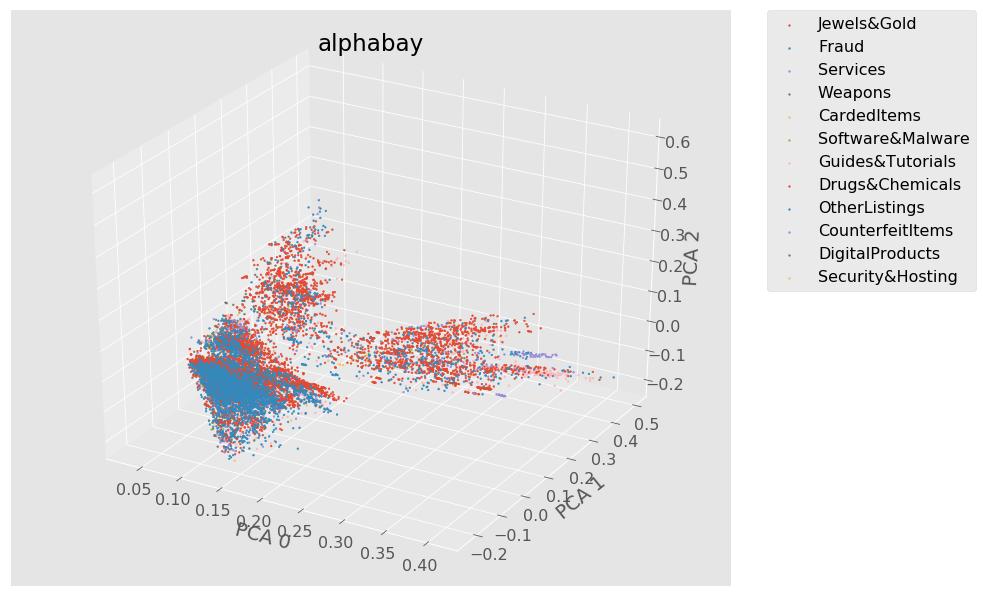

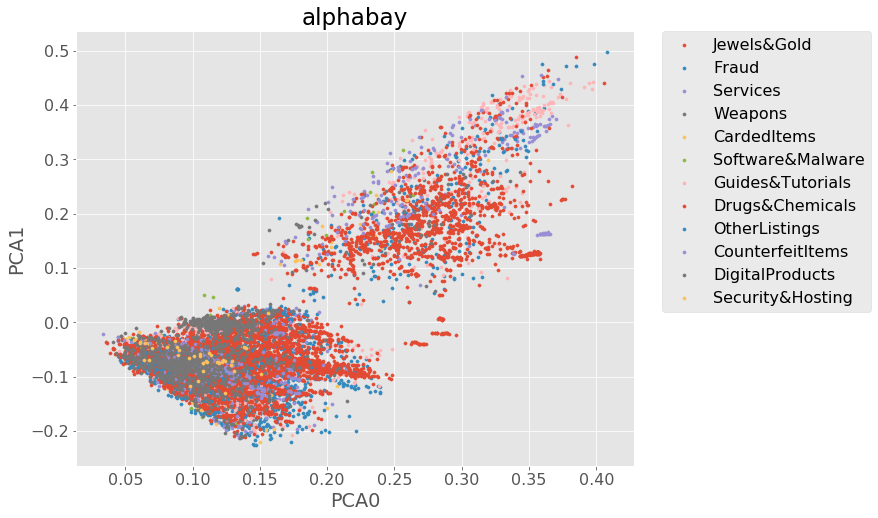

In [ ]:
#
# Problem and target 
#

domain = "alphabay"
problem = category[domain] #[190:3690]
input_data, vocab = tfidf(description[domain]) #[190:3690])
problem_numeric = [sorted(list(set(category[domain]))).index(x) for x in problem]

print("Samples:", len(problem))
print("Features:", input_data.shape[1])


#
# Visualize data
#
plot_data_3d()
plot_data_2d()


#
# Check BOW-model feature restraints
#

feat_impact(domain, start=10, stop=2500, step=100)

#
# Check when exp. var > treshold (nm of useful features) 
#

dims = scree(7500, .95)


#
# Train models 
#

# clf = create_clf(input_data)
# clfD = (clf, input_data, "none", "{} - Default".format(input_data.shape[1]))
# clfs = [clfD]
clfs = []
for x in tqdm([dims, int(dims/2), 5, 3]):
    input_, pca = red_dim(input_data, x)
    clf = create_clf(input_)
    clfs.append((clf, input_, pca, "{}dim".format(x)))
    
#
# Display result
#

plot_clfs(clfs)


#
# Result F1 & Confusion matrix
#

for clf_ in clfs:
    eval_clf(clf_)
    plot_confusion_matrix(clf_, normalize=True)
